# Training Simpsons Image Classification Model
To do a reverse-search on the Simpsons image repository (user uploads an image expecting the search engine to find similar images), we consider deep learning as a solution. Once the program knows how to classify the image (image -> text), we can use the text to search for similar images in the repository (file names are assumed to have the Simpsons' characters' name in this project's database). A real-life scenario may require image classification for both the input and search engine possibilities, but for the purpose of simplicity, that will not be considered.

I used [fast.ai](https://www.fast.ai/), a PyTorch wrapper, to fine-tune Resnet, a common convolutional neural network used for solving image classification problems. Since this is a relatively simple problem with very few classes and the problem at hand is at a small scale, using a wrapper like fast.ai rather than TensorFlow or PyTorch to speed up the deep learning code-writing process is reasonable.

# Isolating data classes
Since the image repository only contains 4 characters, we would only consider training 4 classes. However, this Kaggle dataset contains many more characters. If we were to train all these classes, the model would need to be trained with more complexity (more epochs, freezing layers, etc.). As a result, isolating the 4 classes into my own dataset folders would be optimal for this model.

In [1]:
import os
import shutil

def copytree2(source, dest):
    """Copies a directory and its contents from a source to a destination"""
    if not os.path.exists(dest):
        os.mkdir(dest)
    dest_dir = os.path.join(dest,os.path.basename(source))
    shutil.copytree(source,dest_dir)

In [3]:
included_classes = ["bart_simpson", "homer_simpson", "lisa_simpson", "marge_simpson"]
simpsons_dataset_dir = "../input/the-simpsons-characters-dataset/simpsons_dataset"
my_simpsons_dataset_dir = "/kaggle/working/my_simpsons_dataset"

os.mkdir(my_simpsons_dataset_dir)

for directory in os.listdir(simpsons_dataset_dir):
    if directory in included_classes:
        full_dir_path = os.path.join(simpsons_dataset_dir, directory)
        copytree2(full_dir_path, my_simpsons_dataset_dir)

# Creating Dataloaders
In this section of the notebook, we prepare the data by a creating dataloader that perform data augmentation such as randomly resizing and cropping the images. The dataloader is also in charge of splitting the dataset into training and validation sets. Specifically, we use the fast.ai DataBlock API to do this. 

In [17]:
!pip show fastai

Name: fastai
Version: 2.1.8
Summary: fastai simplifies training fast and accurate neural nets using modern best practices
Home-page: https://github.com/fastai/fastai/tree/master/
Author: Jeremy Howard, Sylvain Gugger, and contributors
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: pandas, requests, pyyaml, matplotlib, torchvision, fastprogress, torch, pip, scipy, fastcore, spacy, scikit-learn, packaging, pillow
Required-by: 


In [4]:
from fastai.vision.all import *

In [5]:
DATASET_PATH = Path(my_simpsons_dataset_dir)

In [6]:
mask_datablock = DataBlock(
   get_items=partial(get_image_files,recurse=true),
   get_y=parent_label,
   blocks=(ImageBlock, CategoryBlock), 
   item_tfms=RandomResizedCrop(224, min_scale=0.3),
   splitter=RandomSplitter(valid_pct=0.2, seed=100),
   batch_tfms=aug_transforms(mult=2)
)

In [7]:
dls = mask_datablock.dataloaders(DATASET_PATH)

# Preview of Batch
Here is a preview of a batch of images that were shuffled with the dataloader. The image and the class name are shown respectively.

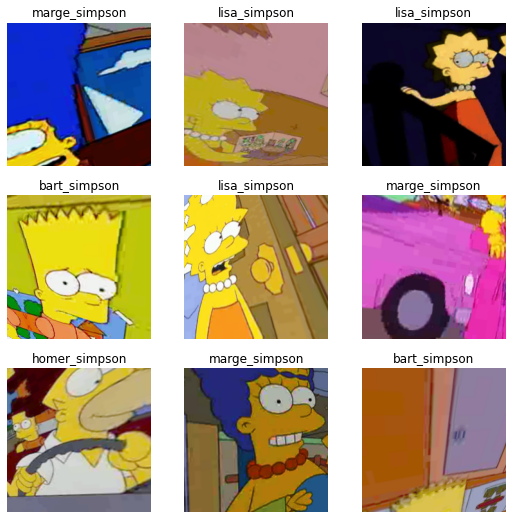

In [8]:
dls.show_batch()

# Fine-tuning Resnet
In this section, we download and fine-tune Resnet. The fast.ai function `cnn_learner` allows us to conveniently download PyTorch models. The metric [accuracy](https://fastai1.fast.ai/metrics.html#accuracy) was chosen because it is primarily used for images that belong to a single class.

In [9]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [10]:
learn.fine_tune(7)

epoch,train_loss,valid_loss,accuracy,time
0,1.292759,0.502172,0.829053,00:36


epoch,train_loss,valid_loss,accuracy,time
0,0.647406,0.182494,0.934992,00:37
1,0.466258,0.087806,0.968700,00:38
2,0.310590,0.079571,0.973515,00:35
3,0.229197,0.059745,0.982343,00:36
4,0.209755,0.049463,0.982343,00:36
5,0.182440,0.041065,0.986356,00:35
6,0.157037,0.041102,0.985554,00:36


After reaching a validation accuracy of 98.56% without overfitting, the model is acceptable to be used in the image repository.

We can now save the model into a `.pkl` file using the `export()` function that fast.ai provides.

In [11]:
learn.export()